# TestingEvaluateClass_TestingZone

# Libraries

In [1]:
# directory set up 
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

# data attainment
import pandas as pd

# mathematical
import tensorflow as tf
import numpy as np

# preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from Extra_Work.PythonFiles.preprocessing import scale_data

# modelling
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LayerNormalization, BatchNormalization, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
# evaluation
from Extra_Work.PythonFiles.modelling import evaluate_models
from Extra_Work.PythonFiles.modelling import FeedForward

# plotting
import matplotlib.pyplot as plt

# setting global seeds
#tf.random.set_seed(1)
#np.random.seed(1)

# Data

In [2]:
# load data

df = pd.read_csv('../Data/dataset2.csv')

X, scalers = scale_data(df[df.columns[:-1]], mode = 'robust')
# for best model, put robust mode. Try with standard too
#X['Spring constant (N per m)'] = 0
#X['Ball radius (mm)'] = 0

y = df[df.columns[-1]]

y_binary = to_categorical(y)

data = train_test_split(
    X,y_binary, test_size = 0.2, random_state = 23
)
X.describe()

,Arm length (m),Ball weight (kg),Ball radius (mm),Air temperature (deg C),Spring constant (N per m),Device weight (kg)
count,4.000000e+03,4000.000000,4.000000e+03,4000.000000,4000.000000,4000.000000
mean,-2.883128e-03,0.001475,2.563953e-01,-0.005958,0.221595,0.000459
std,7.520443e-01,0.743236,9.599955e-01,0.812360,0.905493,0.578888
min,-1.913423e+00,-2.275288,-1.105124e+00,-2.000000,-1.129669,-0.991366
25%,-5.131259e-01,-0.491466,-3.737823e-01,-0.500000,-0.409808,-0.497589
50%,-2.102844e-16,0.000000,-1.160367e-16,0.000000,0.000000,0.000000
75%,4.868741e-01,0.508534,6.262177e-01,0.500000,0.590192,0.502411
max,2.880758e+00,2.713207,7.489261e+00,1.833333,5.936071,1.017495


In [3]:
X = np.asarray(X)

In [4]:
y_binary

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

# Data Exploration

# Model Cell

In [5]:
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.activations import elu, relu
from tensorflow.keras.layers import Activation, PReLU
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Sequential


# add automation to this
def uncompiled_model():
    
    
    model = Sequential()
    
    # adi (guess)
    
    #model.add(Dense(9, activation = 'elu', input_dim = 6))
    #model.add(BatchNormalization())
    #model.add(Dense(8, activation = 'elu',))
    #model.add(BatchNormalization())


    #model.add(Dense(8, activation = 'elu'))
    #model.add(BatchNormalization())

    #model.add(Dense(7, activation = 'elu'))
    #model.add(BatchNormalization())


    # kyriacos' model
    #model.add(Dense(units = 15, activation = 'tanh', input_dim = 6))
    #model.add(Dense(units = 15, activation = 'tanh', input_dim = 6))
    #model.add(Dense(units = 15, activation = 'tanh', input_dim = 6))
    

    # tanh strategy
    
    model.add(Dense(9, activation = 'tanh', input_dim = 6))
    model.add(BatchNormalization())
    model.add(Dense(8, activation = 'tanh',))
    model.add(BatchNormalization())


    model.add(Dense(8, activation = 'tanh'))
    model.add(BatchNormalization())

    model.add(Dense(7, activation = 'tanh'))
    model.add(BatchNormalization())
    
    model.add(Dense(units = 2, activation = 'softmax'))
    
    

# try maxout layers!!!!

    #outputs = Dense(2, activation='sigmoid', name='TargetHit')(x)
    # remember, you might have to make ur output a sigmoid!


    # chris model
    #x = Dense(3, activation='linear')(inputs)
    #outputs = Dense(2, activation = 'sigmoid')(x)
    
    
    return model

# will get penalised for model complexity, make sure you decrease this

def compile_model():
    model = uncompiled_model()
    model.compile(
        #optimizer="adam", # next step, add custom optimizers and modify learning 
        optimizer='adam',
        # rates. Adam yelds the best values
        loss="binary_crossentropy", # binary_crossentropy
        metrics=["accuracy",
                 "binary_accuracy",
                 "binary_crossentropy",
                 "categorical_accuracy"
                 ],
    )
    return model

    

In [6]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping = EarlyStopping(patience = 25)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)


from sklearn.model_selection import KFold
from time import time
def cross_validate(K = 5, **kwargs):
    scores = []
    histories = []
    X = np.concatenate((data[0], data[1]), axis = 0)
    y = np.concatenate((data[2], data[3]), axis = 0)
    for train, test in KFold(n_splits=K, shuffle=True).split(X,y):
        model = compile_model()
        start = time()
        histories.append(model.fit(X[train], y[train],
                                   validation_data = (X[test],y[test]),
                                   **kwargs).history)
        print(time() - start)
        scores.append(model.evaluate(X[test], y[test], verbose = 0))
        
    print("average loss: ", np.asarray(scores)[:,0].mean())
    print("average accuracy: ", np.asarray(scores)[:,1].mean()) # make sure that accuracy is the first metric in compile
    print(model.summary())
    #model = compile_model()
    #model.fit(data[0],data[2],**kwargs)
    #print(model.evaluate(data[1],data[3]))
    return scores, histories

def plot_histories(histories, metrics = ['loss', 'accuracy', 'val_accuracy','val_loss']):
    fig, axes = plt.subplots(nrows = (len(metrics) - 1) // 2 + 1, ncols = 2, figsize = (16,16))
    axes = axes.reshape((len(metrics) - 1) // 2 + 1, 2)
    for i,metric in enumerate(metrics):
        for history in histories:
            axes[(i+2)//2 - 1, 1 - (i+1)%2].plot(history[metric])
            axes[(i+2)//2 - 1, 1 - (i+1)%2].axhline(y=max(history[metric]))
            axes[(i+2)//2 - 1, 1 - (i+1)%2].set_xticks(
                np.arange(max(history[metric]))
            )
                
            
        plt.legend([i for i in range(len(histories))])
        


In [7]:
scores, histories = cross_validate(K = 5, 
                                   epochs = 500,
                                   # set to 1000 for good performance on YOUR model
                                   verbose = 0,
                                   batch_size = 128, # best when set to 50, 128 does not work bad either? So does 156! Early stopping will probably really help you model !
                                   # set to 128 for your model
                                   shuffle = True)
                                   #callbacks = [reduce_lr])
#validation_split = 0.1, callbacks = [early_stopping]) #)
print(scores)

# try supplying customw weights, also see below suggestions

65.90370774269104
53.73361301422119
74.40374708175659
67.43571996688843
50.5867977142334
average loss:  0.31088113188743594
average accuracy:  0.8807500004768372
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 9)                 63        
_________________________________________________________________
batch_normalization_16 (Batc (None, 9)                 36        
_________________________________________________________________
dense_21 (Dense)             (None, 8)                 80        
_________________________________________________________________
batch_normalization_17 (Batc (None, 8)                 32        
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 72        
_________________________________________________________________
batch_normalization_18 (

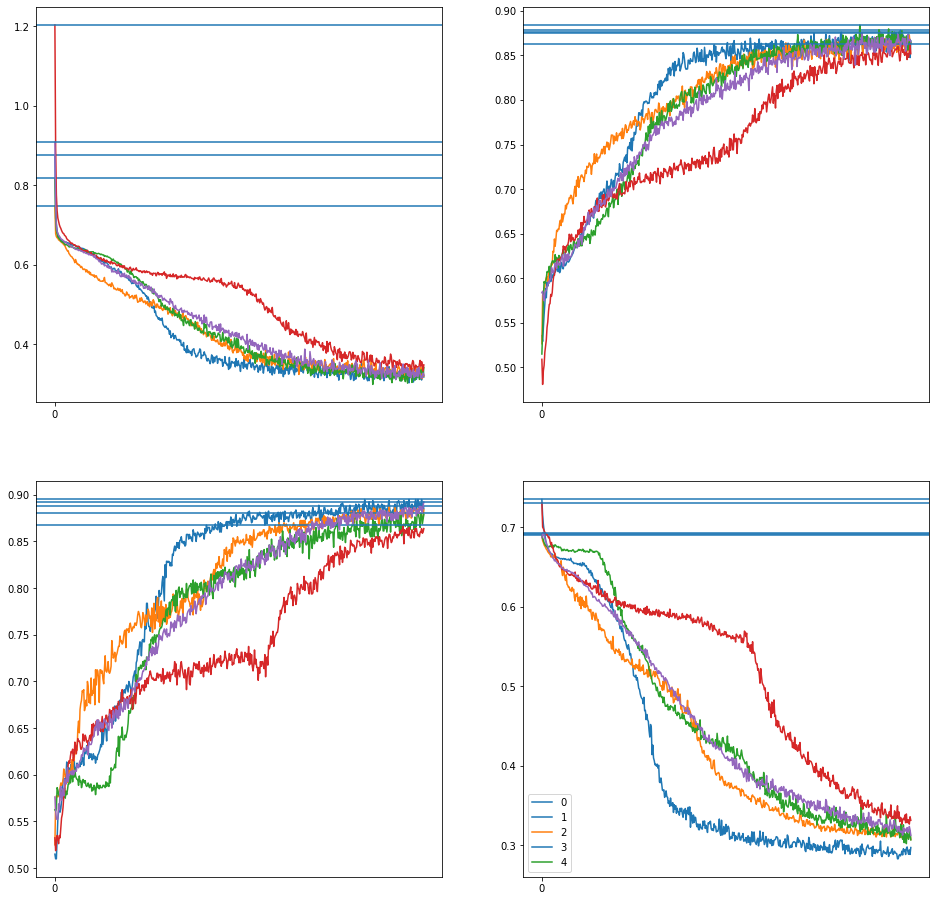

In [8]:
plot_histories(histories)